# Project

#### by Tianyang Gu，Zijin Wan, Jiashun he

### import some library

In [1]:
import os
import sys
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import sklearn
from sklearn.metrics import roc_auc_score

### confirm the GPU

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#tf.config.experimental.list_physical_devices('GPU')

### Work on dataset, here we use the tf.dataset to load and proprecess data

In [3]:
#the dictionay for label
dic={'damage':0,'no_damage':1}

In [4]:
#prepare the preprocess function when reading the data
def preprocess(path, label):
    # read image
    image = tf.io.read_file(path) 
    #decode 
    image = tf.image.decode_jpeg(image, channels=3)
    # rsize o the same input size of resnet 
    image = tf.image.resize(image, [224, 224]) 
     # normalize
    image /= 255.0 
    return image, label

In [5]:
#prepare the image augument function
def image_aug(img,label):
    #random contrast
    #img = tf.image.random_contrast(img,lower=0.9,upper=1.8)
    #random saturration
    #img = tf.image.random_saturation(img,lower=0.8,upper=1.2)
    #random flip up and down
    img=tf.image.random_flip_up_down(img)
    #random flip left and right
    img=tf.image.random_flip_left_right(img)
    return img, label

In [6]:
#the function to get dataset 
def get_dataset(path_trans):
    #get the path to dataset
    data_path_train = pathlib.Path(path_trans,encoding='unicode_escape')
    #get the last two level of the whole path , like damage/111.jpeg or no_damage/11111.jpeg
    all_image_paths_train = list(data_path_train.glob('*/*')) 
    #transform all path to string, preparing for reading 
    all_image_paths_train = [str(path) for path in all_image_paths_train]
    #get the label, damage or no_damage
    label_names_train = sorted(item.name for item in data_path_train.glob('*/') if item.is_dir())
    #transform damage to 0, no_damage to 1
    all_image_labels_train = [dic[pathlib.Path(path).parent.name] for path in all_image_paths_train]
    #get the data path and label
    ds_train = tf.data.Dataset.from_tensor_slices((all_image_paths_train, all_image_labels_train))
    #preprocess fuciton, transform the data path to data and other preprocess
    ds_train=ds_train.map(preprocess)
    return ds_train

In [7]:
#get validation data
ds_validation=get_dataset('p_data/validation_another')

In [8]:
#get training data
ds_train=get_dataset('p_data/train_another')

In [9]:
#do img augument on training data 
ds_train_a=ds_train.map(image_aug)
ds_validation_a=ds_validation.map(image_aug)

In [10]:
ds_test=get_dataset('p_data/test_another')

In [11]:
ds_test_1=get_dataset('p_data/test')

In [12]:

ds_test_a=ds_test.map(image_aug)

### show some data in trianing data

In [13]:
ds_train_a = ds_train_a.shuffle(100,reshuffle_each_iteration=True)
data=ds_train_a.take(4).as_numpy_iterator()

In [14]:
datas=[]
for element in data:
    datas.append(element)

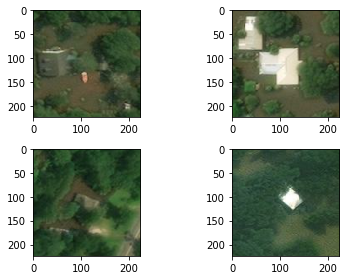

In [15]:
#draw the data
f, ax = plt.subplots(2,2)
ax[0][0].imshow(datas[0][0], cmap='jet')
ax[0][1].imshow(datas[1][0], cmap='jet')
ax[1][0].imshow(datas[2][0], cmap='jet')
ax[1][1].imshow(datas[3][0], cmap='jet')
plt.tight_layout()
plt.show()

In [16]:

'''
#import the resnet50 as base model, with maxpooling and not incldue fully connected layers
base_model1=tf.keras.applications.ResNet50V2(pooling=max,include_top=False,input_shape=(224, 224, 3))
base_model2=tf.keras.applications.Xception(pooling=max,include_top=False,input_shape=(224, 224, 3))

for layer in base_model1.layers[:]:
  layer.trainable=False
for layer in base_model2.layers[:]:
  layer.trainable=False
'''

'\n#import the resnet50 as base model, with maxpooling and not incldue fully connected layers\nbase_model1=tf.keras.applications.ResNet50V2(pooling=max,include_top=False,input_shape=(224, 224, 3))\nbase_model2=tf.keras.applications.Xception(pooling=max,include_top=False,input_shape=(224, 224, 3))\n\nfor layer in base_model1.layers[:]:\n  layer.trainable=False\nfor layer in base_model2.layers[:]:\n  layer.trainable=False\n'

In [17]:
#base_model.trainable = False

In [18]:
#show the summary of base mdoel
#base_model.summary()

In [19]:
#here to build model after the resnet


In [20]:
#tf.keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

In [21]:
def progressbar(n_step, n_total):
    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

In [22]:

'''
n_total =20
epoch = 10
train_batch = 6000
val_batch =500
n_total =1
epoch = 1
train_batch = 60
val_batch =5
y_pred = [None]*n_total
model = [None]*n_total

for i in range(n_total): 
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model1(inputs)
    x2 = base_model2(inputs)
    

    ds_train_a = ds_train_a.shuffle(15000,reshuffle_each_iteration=True)
    ds_train_bootstrapSamples = ds_train_a.take(train_batch)
    ds_validation_a = ds_validation_a.shuffle(1500,reshuffle_each_iteration=True) 
    ds_validation_bootstrapSamples = ds_validation_a.take(val_batch)  

    concat = tf.keras.layers.concatenate([x,x2])
    #x = base_model(inputs)
    #use the gloval average pooling

    GlobalAveragePooling2D = tf.keras.layers.GlobalAveragePooling2D() 
    x=GlobalAveragePooling2D(concat)
    #use dropout
    x = tf.keras.layers.Dropout(0.5)(x)
    #add a layer with 128 nodes
    x=tf.keras.layers.Dense(128,activation='relu')(x)
    #use dropout
    x = tf.keras.layers.Dropout(0.5)(x)
    #add a layer with 64 nodes
    x=tf.keras.layers.Dense(64,activation='relu')(x)
    #the output layer,1 nodes with sigmoid function
    outputs=tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model[i] = tf.keras.Model(inputs, outputs)#compile the model
    model[i].compile(optimizer=tf.keras.optimizers.Adam(lr=0.003),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)
   
    history = model[i].fit(ds_train_bootstrapSamples.batch(16).prefetch(2),
                    epochs=epoch,validation_data=ds_validation_bootstrapSamples.batch(64).prefetch(2) ,callbacks=[callback])
    progressbar(i,n_total)
'''

"\nn_total =20\nepoch = 10\ntrain_batch = 6000\nval_batch =500\nn_total =1\nepoch = 1\ntrain_batch = 60\nval_batch =5\ny_pred = [None]*n_total\nmodel = [None]*n_total\n\nfor i in range(n_total): \n    inputs = tf.keras.Input(shape=(224, 224, 3))\n    x = base_model1(inputs)\n    x2 = base_model2(inputs)\n    \n\n    ds_train_a = ds_train_a.shuffle(15000,reshuffle_each_iteration=True)\n    ds_train_bootstrapSamples = ds_train_a.take(train_batch)\n    ds_validation_a = ds_validation_a.shuffle(1500,reshuffle_each_iteration=True) \n    ds_validation_bootstrapSamples = ds_validation_a.take(val_batch)  \n\n    concat = tf.keras.layers.concatenate([x,x2])\n    #x = base_model(inputs)\n    #use the gloval average pooling\n\n    GlobalAveragePooling2D = tf.keras.layers.GlobalAveragePooling2D() \n    x=GlobalAveragePooling2D(concat)\n    #use dropout\n    x = tf.keras.layers.Dropout(0.5)(x)\n    #add a layer with 128 nodes\n    x=tf.keras.layers.Dense(128,activation='relu')(x)\n    #use dropout\

In [23]:
#l,a=model[0].evaluate(ds_test.batch(512))
#print(f'The accuracy on balanced test is {a}')
n_total =20
model=[]
for i in range(n_total): 
    model.append(tf.keras.models.load_model(f'm/model{i}'))

In [ ]:
delay_avg = []
PPR = []
bagging_result = []
test_result = []
print(n_total)
#l = 0
print(i)
i=0
for data in ds_test_1:
    #l=l+1
    delay_hist = [None]*n_total
    itr = 0
    for j in range(n_total): 
        datas=np.expand_dims(data[0],axis=0)
        delay_hist[j] = model[j](datas)
        delay_hist[j]=1 if delay_hist[j]>=0.5 else 0
        itr = (itr+1) if delay_hist[j] > 0.5 else itr
    #
    test_result.append(np.expand_dims(data[1],axis=0))
    delay_avg.append(np.mean(delay_hist))

    PPR.append((itr/n_total) if (delay_avg[i]<0.5) else (1-itr/n_total)) #calculate the ppr
    bagging_result.append(0 if (delay_avg[i]<0.5) else 1)
    #if(l>5):break
    i+=1
    print(i)
#

20
19
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

In [ ]:
print(test_result)
print(delay_avg)
merge_list = np.c_[delay_avg, test_result]
#col=np.sum(merge_list[:,2]) 
try:
    roc_auc_score(merge_list[:,1],merge_list[:,0])
except ValueError:
    pass
